In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTTCTCCTTTGCGC...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCACAAACAGGTTGGTCCTCCTTTTTTCTAAG...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACCTCCCACGGCGAGGCACTTTGTTGCCCCACCTCCACGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGATCGCCCGCAGCGACGCAATTGCGGAGTAAGCGCGTG...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATTTAACTCATGGTCCATCCGTCCCTGAGCGCACTTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCGGGTATATGTTCT...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCCTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCGCAGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGGTTGACACAATGAAACGACAACCTGTTCGTC...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 35814.19it/s]


[42, 241, 410, 607, 779, 1005, 1161, 1358, 1501, 1670, 1833, 1957, 2094, 2215, 2359, 2518, 2593, 2744, 2844, 2953, 3070, 3189, 3270, 3365, 3412, 3578, 3632, 3690, 3806, 3869, 3983, 4066, 4088, 4189, 4244, 4363, 4435, 4379, 4473, 4566, 4623, 4637, 4743, 4819, 4753, 4876, 4820, 4867, 4879, 5006, 5011, 5042, 5076, 5069, 5193, 5213, 5199, 5094, 5084, 5054, 5024, 5034, 4939, 4933, 4917, 4818, 4772, 4722, 4753, 4652, 4573, 4561, 4417, 4421, 4370, 4293, 4219, 4167, 4065, 3938, 3968, 3776, 3762, 3616, 3623, 3460, 3386, 3318, 3206, 3076, 2964, 2833, 2715, 2639, 2491, 2354, 2180, 2084, 1959, 1755, 1600, 1478, 1305, 1151, 950, 746, 550, 356, 183, 26]


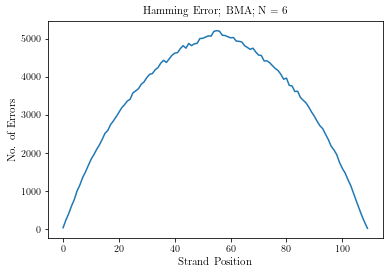

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-our-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:16<00:00, 613.85it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


G -> CAT 6
AGAC ->  6
TG -> CC 6
AA -> CC 6
AC -> TT 6
GAT -> C 6
 -> TTAT 6
C -> TTTT 6
TGCG ->  6
GCAG ->  6
CA -> TT 6
A -> TTG 6
TCC ->  6
 -> CTTG 6
TAT ->  6
A -> TTTTT 6
G -> TAA 6
 -> CGAC 6
GTAC ->  6
ATAG ->  6
GACT ->  6
ACTA ->  6
 -> GAT 6
TGAG ->  6
GG -> CC 6
 -> TTAC 6
AGT -> C 6
 -> GTTG 6
T -> CAA 6
TTC ->  6
A -> CGC 6
 -> AGC 6
 -> TTTC 6
GA -> CCC 6
T -> CCA 6
G -> TCCC 6
 -> TATA 6
TACG ->  7
A -> TGT 7
C -> TTA 7
 -> TCCG 7
GCTA ->  7
G -> TCTT 7
 -> CGCC 7
 -> TCTT 7
 -> CATC 7
 -> TTCA 7
G -> ATC 7
G -> AAC 7
CG -> AT 7
 -> AATT 7
 -> CACC 7
G -> CAA 7
TGA -> C 7
G -> CTA 7
T -> ACC 7
ACGG ->  7
 -> GCA 7
 -> ATTT 7
 -> CAAC 7
 -> ACCT 7
ACG -> T 7
C -> ATT 7
GGC -> T 7
 -> AACA 8
AAA ->  8
TT -> C 8
 -> CCCA 8
 -> TCTC 8
G -> TAC 8
 -> CCTT 8
TC -> A 8
CTAG ->  8
TAG -> C 8
G -> TCT 8
TTG ->  8
 -> GCCC 8
A -> GCC 8
 -> TTTA 8
ACC ->  8
 -> ACTT 8
 -> AAG 8
 -> TCCC 9
CAC ->  9
GT -> CC 9
G -> ATA 9
 -> CAG 9
A -> GTT 9
 -> ATG 9
GC -> TT 9
TTA ->  9
G -> AAT 

 -> CCT @ 55 6
AG ->  @ 38 6
A -> G @ 94 6
TT ->  @ 55 6
 -> CC @ 74 6
G -> CC @ 62 6
 -> TCC @ 53 6
T -> A @ 83 6
T -> A @ 98 6
T -> G @ 71 6
G -> CC @ 53 6
GA ->  @ 86 6
GA ->  @ 81 6
A -> CC @ 89 6
T -> G @ 33 6
G -> CC @ 66 6
AG ->  @ 22 6
C -> A @ 107 6
T -> A @ 91 6
A -> G @ 20 6
C -> A @ 102 6
TG ->  @ 42 6
GG ->  @ 57 6
GG ->  @ 56 6
GG ->  @ 47 6
TG ->  @ 52 6
 -> CT @ 64 6
TG ->  @ 53 6
TG ->  @ 59 6
T -> G @ 74 6
 -> G @ 5 6
A -> CC @ 28 6
G -> TT @ 24 6
 -> CT @ 67 6
CC ->  @ 56 6
G -> A @ 109 6
A -> CC @ 21 6
A -> CC @ 20 6
 -> CC @ 89 6
TG ->  @ 74 6
TG ->  @ 76 6
A -> TT @ 81 6
CT ->  @ 42 6
A -> CT @ 38 6
A -> TT @ 89 6
 -> GCC @ 56 6
C -> G @ 37 6
 -> TC @ 25 6
A -> CC @ 40 6
A -> CC @ 41 6
GG ->  @ 64 6
C -> TT @ 53 6
T -> A @ 78 6
T -> G @ 29 6
T -> A @ 64 6
 -> CT @ 31 6
T -> C @ 10 6
T -> A @ 75 6
T -> A @ 72 6
AG ->  @ 34 6
G -> CC @ 8 6
A -> CC @ 58 6
T -> A @ 71 6
A -> CC @ 57 6
G -> TT @ 53 6
G -> CC @ 82 6
A -> CC @ 53 6
T -> C @ 53 6
GG ->  @ 82 6
G -> TT @ 4

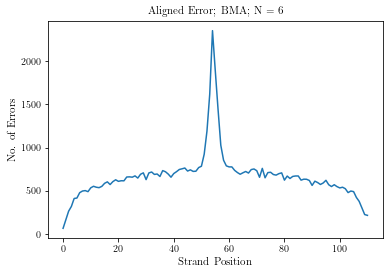

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-our-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 31, 41, 61, 50, 63, 75, 66, 69, 60, 67, 65, 50, 69, 67, 69, 89, 74, 73, 68, 85, 72, 85, 82, 71, 83, 69, 78, 78, 77, 65, 92, 77, 70, 86, 80, 86, 81, 76, 67, 83, 71, 74, 87, 91, 74, 88, 72, 90, 82, 76, 56, 84, 82, 123, 128, 88, 68, 77, 69, 82, 77, 71, 88, 87, 86, 88, 84, 88, 87, 101, 69, 93, 71, 106, 81, 86, 80, 89, 73, 86, 87, 79, 74, 77, 77, 66, 82, 79, 67, 82, 75, 76, 69, 74, 79, 74, 67, 80, 64, 77, 61, 77, 66, 66, 81, 57, 58, 45, 49, 45]
[0, 20, 26, 27, 42, 43, 51, 42, 53, 50, 46, 62, 52, 53, 54, 52, 60, 48, 52, 57, 57, 52, 46, 61, 49, 65, 60, 58, 62, 56, 67, 61, 67, 56, 64, 62, 56, 68, 47, 61, 63, 61, 59, 60, 58, 53, 73, 55, 49, 61, 53, 59, 59, 70, 117, 116, 63, 62, 52, 68, 65, 69, 51, 44, 59, 63, 62, 65, 61, 57, 70, 54, 57, 58, 62, 66, 53, 65, 59, 72, 60, 52, 60, 61, 61, 61, 46, 55, 58, 58, 60, 65, 65, 58, 54, 63, 54, 37, 65, 72, 55, 59, 47, 57, 63, 39, 43, 45, 32, 34, 26]
[18, 12, 26, 25, 26, 26, 20, 37, 36, 19, 35, 28, 39, 22, 36, 26, 31, 39, 37, 38, 38, 37, 26, 47, 36, 31, 3

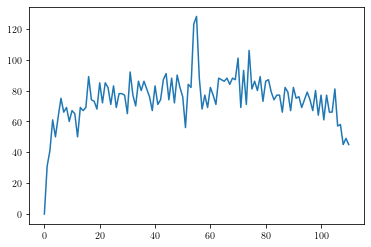

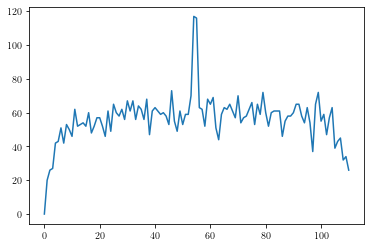

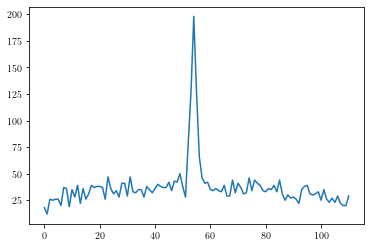

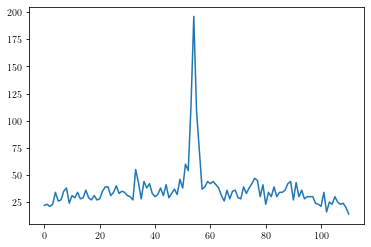

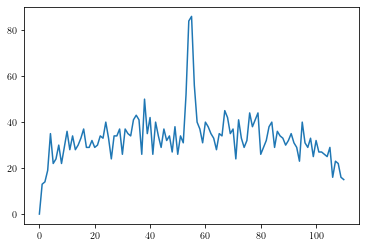

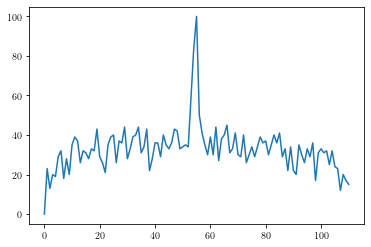

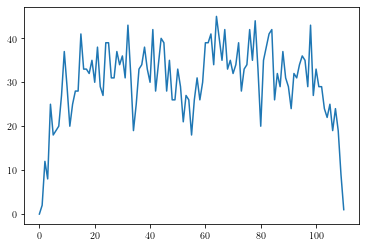

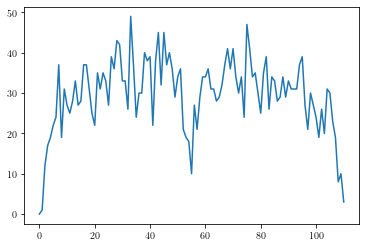

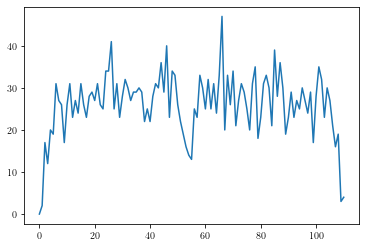

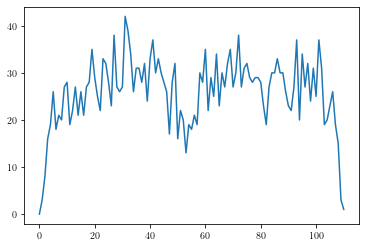

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)